## ACELERADEV DATA SCIENCE
## ENEM 2016 REGRESSION EXERCISE

### Eighth module - Predict ENEM 2016 math score

Goal: create a model to predict the math test scores from ENEM 2016 participants. Use train.csv to train a model and test.csv to predict the math test score (column `NU_NOTA_MT`). Save your answer in an archive named answer.csv with two columns: `NU_INSCRICAO` and `NU_NOTA_MT`.

### Oitavo módulo - Prever nota de matemática do ENEM 2016

Objetivo: criar um modelo para prever a nota da prova de matemática de quem participou do ENEM 2016. No arquivo test.csv crie um modelo para prever nota da prova de matemática (coluna `NU_NOTA_MT`) de quem participou do ENEM 2016. Salve sua resposta em um arquivo chamado answer.csv com duas colunas: `NU_INSCRICAO` e `NU_NOTA_MT`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

In [2]:
sns.set_style('whitegrid')
%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(6, 6)

sns.set()

### Import Data

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### Exploratory Data Analysis

#### Checking train and test sets sizes

In [4]:
print(f'Train set size: {train_df.shape}\nTest set size:{test_df.shape}')
print('\nIs every column of the test set in the train set?')
print(f'{np.all([(test_col in train_df.columns) for test_col in test_df.columns])}')

Train set size: (13730, 167)
Test set size:(4576, 47)

Is every column of the test set in the train set?
True


In [5]:
train_df.shape

(13730, 167)

In [6]:
train_df.describe()

,Unnamed: 0,NU_ANO,CO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,NU_IDADE,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,...,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041
count,13730.000000,13730.0,1.373000e+04,13730.000000,13730.000000,13202.000000,13730.000000,13730.000000,1.312100e+04,13121.000000,...,6354.000000,6354.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,2938.000000
mean,2288.173926,2016.0,3.088548e+06,30.736708,21.593809,0.116043,2.185652,1.048871,3.057946e+06,30.429159,...,4.530217,3.962858,4.645594,4.678441,3.341515,4.458995,3.724618,3.506409,4.442098,3.671545
std,1321.230607,0.0,9.890495e+05,9.862405,7.043654,0.365986,1.007285,0.258895,9.703020e+05,9.670030,...,1.027613,1.625356,0.920998,0.865039,1.711930,1.200172,1.689362,1.718858,1.181549,1.746444
min,0.000000,2016.0,1.100023e+06,11.000000,13.000000,0.000000,0.000000,0.000000,1.100023e+06,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1144.000000,2016.0,2.307650e+06,23.000000,17.000000,0.000000,1.000000,1.000000,2.306900e+06,23.000000,...,5.000000,3.000000,5.000000,5.000000,2.000000,5.000000,3.000000,2.000000,4.000000,3.000000
50%,2288.000000,2016.0,3.118601e+06,31.000000,19.000000,0.000000,3.000000,1.000000,3.106200e+06,31.000000,...,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000
75%,3432.000000,2016.0,3.550308e+06,35.000000,23.000000,0.000000,3.000000,1.000000,3.549805e+06,35.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,4586.000000,2016.0,5.300108e+06,53.000000,67.000000,3.000000,5.000000,4.000000,5.300108e+06,53.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


#### Control df

In [7]:
def makeControlDf(df):
    '''
    Create a dataframe with the input columns' names, dtypes, percentage of missing values,
    number of unique values and rate of unique values.
    :param df: pandas DataFrame
    :return: pandas DataFrame with features 'column', 'dtype', 'missing_pct', 'uniques' and 'unique_rate'
    '''
    control_df = pd.DataFrame({'column':df.columns,
                               'dtype':df.dtypes,
                               'missing_pct':(100*df.isna().sum()/df.shape[0]).round(2),
                               'uniques':df.nunique(),
                               'unique_rate':(100*df.nunique()/df.shape[0]).round(2)}).reset_index(drop=True)
    return control_df
control_df = makeControlDf(train_df)
control_df

,column,dtype,missing_pct,uniques,unique_rate
0,Unnamed: 0,int64,0.00,4587,33.41
1,NU_INSCRICAO,object,0.00,13730,100.00
2,NU_ANO,int64,0.00,1,0.01
3,CO_MUNICIPIO_RESIDENCIA,int64,0.00,2709,19.73
4,NO_MUNICIPIO_RESIDENCIA,object,0.00,2632,19.17
5,CO_UF_RESIDENCIA,int64,0.00,27,0.20
6,SG_UF_RESIDENCIA,object,0.00,27,0.20
7,NU_IDADE,int64,0.00,55,0.40
8,TP_SEXO,object,0.00,2,0.01
9,TP_ESTADO_CIVIL,float64,3.85,4,0.03


#### Function to drop columns 

In [8]:
def dropColumns(df, cols):
    '''
    Drop required columns from pandas DataFrame
    :param df: pandas DataFrame
    :param columns_to_drop: list with strings related to the DataFrame's columns.
    :return: pandas DataFrame without required features.
    '''
    for col in cols:
        if col in df.columns.values:
            df.drop(col, axis=1, inplace=True)

#### Checking rows and columns with missing values

The graphic below shows us the percentage of missing values per row.

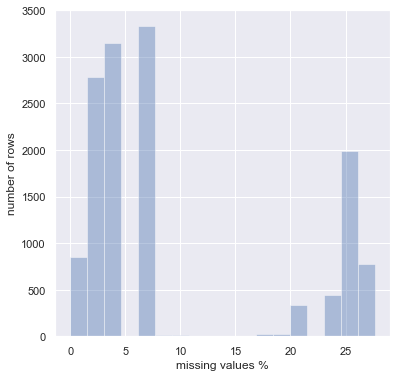

In [9]:
def missingPerRow(df):
    '''
    Return a Pandas Series with missing value percentage per rows.
    :param df: Pandas DataFrame from which the percentages are to be calculated
    :return: Pandas Series with missing percentage per row.
    '''
    mpr = (100*df.isna().sum(axis=1)/df.shape[1]).round(2)
    return mpr

mpr = missingPerRow(train_df[test_df.columns])

sns.distplot(mpr, kde=False)
plt.ylabel('number of rows')
plt.xlabel('missing values %');

In [10]:
print(f'Number of rows with more than 15% missing values: {train_df[test_df.columns][mpr > 15].shape[0]}')

Number of rows with more than 15% missing values: 3597


There are 3573 rows in which the percentage of missing values is higher than 20%.  
Let's first impute the NAN values of the target feature (i.e. where `NU_NOTA_MT` is NaN), and the remaining test grade features for other subjects, and see the difference in the distribution. As seen below, there are 3597 rows in which the math test value is absent.

In [11]:
null_target_index = np.where(train_df['NU_NOTA_MT'].isna())[0]
print(f'Number of missing rows from NU_NOTA_MT: {len(null_target_index)}')

Number of missing rows from NU_NOTA_MT: 3597


There's a flag feature for each test that tells us if the student was present during the test (0 for not present) or if she was eliminated (2 for eliminated), so we can impute the missing values with zeroes in the test grade features. These are:  
* `TP_PRESENCA_MT` for the math test (`NU_NOTA_MT`)  
* `TP_PRESENCA_CN` for the math test (`NU_NOTA_CN`)  
* `TP_PRESENCA_CH` for the math test (`NU_NOTA_CH`)  
* `TP_PRESENCA_LC` for the math test (`NU_NOTA_LC`)  

In [12]:
pd.concat([
    train_df.groupby(['TP_PRESENCA_MT']).sum()['NU_NOTA_MT'],
    train_df.groupby(['TP_PRESENCA_CN']).sum()['NU_NOTA_CN'],
    train_df.groupby(['TP_PRESENCA_CH']).sum()['NU_NOTA_CH'],
    train_df.groupby(['TP_PRESENCA_LC']).sum()['NU_NOTA_LC']], axis=1)

,NU_NOTA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC
0,0.0,0.0,0.0,0.0
1,4889151.5,4896413.4,5477225.3,5233419.3
2,0.0,0.0,0.0,0.0


In [13]:
def fillGrades(x):
    '''
    Impute missing values from test grades based on the respective flags for students'
    presence during the test and test elimination/validity status.
    :param x: to be used with Pandas apply method, represent two positional list.
    First position is flag, second is test grade.
    :return: missing values are imputed with 0 if the flag is 0 or 2. Else, original
    grade is returned.
    '''
    flag=x[0]
    grade=x[1]
    if flag in [0, 2]:
        return 0
    else:
        return grade

test_grades = ['NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC']
flags = ['TP_PRESENCA_MT', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC']
for flag, test_grade in zip(flags, test_grades):
    train_df[test_grade] = train_df[[flag, test_grade]].apply(fillGrades, axis=1)

control_df = makeControlDf(train_df)

In [14]:
print(f"Number of missing rows from NU_NOTA_MT: {len(np.where(train_df['NU_NOTA_MT'].isna())[0])}")

Number of missing rows from NU_NOTA_MT: 0


Let's also fill up our test features based in these same rules.

In [15]:
test_grades = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC']
flags = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC']
for flag, test_grade in zip(flags, test_grades):
    test_df[test_grade] = test_df[[flag, test_grade]].apply(fillGrades, axis=1)

The written essay test, `NU_NOTA_REDACAO`, was given the same day as the math test, so if the student wasn't present this day, he didn't get a grade in any of the essay related tests. Let's impute these with zeroes.

In [16]:
pd.concat([
    train_df.groupby(['TP_PRESENCA_MT']).sum()['TP_STATUS_REDACAO'],
    train_df.groupby(['TP_PRESENCA_MT']).sum()['NU_NOTA_COMP1'],
    train_df.groupby(['TP_PRESENCA_MT']).sum()['NU_NOTA_COMP2'],
    train_df.groupby(['TP_PRESENCA_MT']).sum()['NU_NOTA_COMP3'],
    train_df.groupby(['TP_PRESENCA_MT']).sum()['NU_NOTA_COMP4'],
    train_df.groupby(['TP_PRESENCA_MT']).sum()['NU_NOTA_COMP5'],
    train_df.groupby(['TP_PRESENCA_MT']).sum()['NU_NOTA_REDACAO']], axis=1)

,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO
TP_PRESENCA_MT,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11164.0,1214052.0,1134044.0,1082450.0,1146285.0,784015.0,5360846.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
essay_grades = ['TP_STATUS_REDACAO',
                'NU_NOTA_COMP1',
                'NU_NOTA_COMP2',
                'NU_NOTA_COMP3',
                'NU_NOTA_COMP4',
                'NU_NOTA_COMP5',
                'NU_NOTA_REDACAO']

flag = 'TP_PRESENCA_MT'
for essay_grade in essay_grades:
    train_df[essay_grade] = train_df[[flag, essay_grade]].apply(fillGrades, axis=1)

control_df = makeControlDf(train_df)

Again, let's also fill up our test features based in these same rules. The flag `TP_PRESENCA_LC` have the same information as the flag `TP_PRESENCA_MT` because the testes that they're related to were given in the same day.

In [18]:
flag = 'TP_PRESENCA_LC'
for essay_grade in essay_grades:
    test_df[essay_grade] = test_df[[flag, essay_grade]].apply(fillGrades, axis=1)

Now that there are way fewer missing values in our target feature and in the rest of the grades, let's focus on the remaining features (columns).

#### Checking columns with missing values

Let's remove the `NU_INSCRICAO` column from the training set, it behaves as an ID column and it is useless to train the model.
The train and test sets have different features dimension. Let's use the same columns available in the test set to train our model (plus the target).

In [19]:
initial_columns = ['NU_NOTA_MT'] + list(test_df.columns)
train_df = train_df[initial_columns]
train_df.drop(columns=['NU_INSCRICAO'], axis=1, inplace=True)
control_df = makeControlDf(train_df)

Let's  first get only the columns that we also have in the test dataset, and then take a look at the columns with missing values.

In [20]:
control_df.sort_values(by='missing_pct', ascending=False)

,column,dtype,missing_pct,uniques,unique_rate
12,TP_DEPENDENCIA_ADM_ESC,float64,68.81,4,0.03
10,TP_ENSINO,float64,68.81,3,0.02
45,Q027,object,53.70,13,0.09
36,NU_NOTA_COMP4,float64,0.00,14,0.10
27,CO_PROVA_MT,object,0.00,9,0.07
28,NU_NOTA_CN,float64,0.00,2692,19.61
29,NU_NOTA_CH,float64,0.00,2978,21.69
30,NU_NOTA_LC,float64,0.00,2774,20.20
31,TP_LINGUA,int64,0.00,2,0.01
32,TP_STATUS_REDACAO,float64,0.00,10,0.07


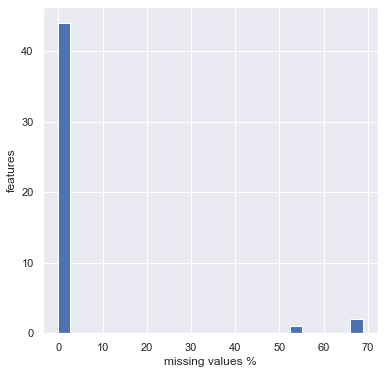

In [21]:
sns.distplot(a=control_df['missing_pct'], bins=25, kde=False, hist_kws={'alpha':1})
plt.ylabel('features')
plt.xlabel('missing values %');

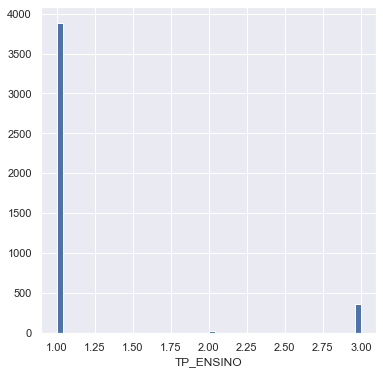

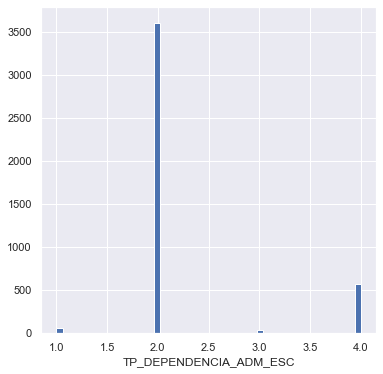

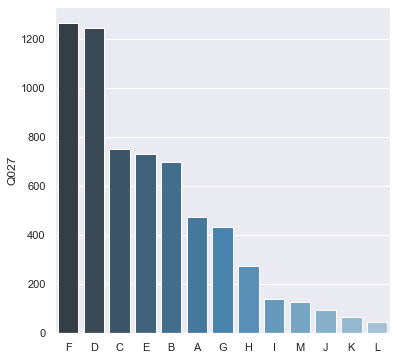

In [22]:
for col in control_df[(control_df['missing_pct']!=0)]['column']:
    fig = plt.figure()
    if train_df[col].dtype != 'object':
        sns.distplot(train_df[col].dropna(), kde=False, hist_kws={'alpha':1})
    else:
        sns.barplot(x=train_df[col].value_counts().index,
                    y=train_df[col].value_counts(),
                    palette='Blues_d')

The features `TP_ENSINO` and `TP_DEPENDENCIA_ADM_ESC` have far too many missing values, so we'll remove them and add them to a list for later use on the test dataset.  

In [23]:
columns_to_drop = ['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC']

dropColumns(df=train_df, cols=columns_to_drop)
control_df = makeControlDf(train_df)

columns_to_drop

['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC']

The variable `Q027` appears to be interesting though, it denotes from which age the student started working, and the missing values may denote that the student never worked - the previous question, `Q026`, actually asks if the student have worked before or works. If the answer is A, then the student never worked, so the next question cannot be answered.

In [24]:
print('Do all students that answer A to question 26 have missing values in question 27?')
print(np.all(train_df[train_df['Q026'] == 'A']['Q027'].isna()))

print('\nDo any students that answer B to question 26 have missing values in question 27?')
print(np.any(train_df[train_df['Q026'] == 'B']['Q027'].isna()))
print('How many missing values are these?')
print(train_df[train_df['Q026'] == 'B']['Q027'].isna().sum())

print('\nDo any students that answer C to question 26 have missing values in question 27?')
print(np.any(train_df[train_df['Q026'] == 'C']['Q027'].isna()))
print('How many missing values are these?')
print(train_df[train_df['Q026'] == 'C']['Q027'].isna().sum())

Do all students that answer A to question 26 have missing values in question 27?
True

Do any students that answer B to question 26 have missing values in question 27?
True
How many missing values are these?
92

Do any students that answer C to question 26 have missing values in question 27?
True
How many missing values are these?
66


So this implies that we'll be able to impute the values of `Q027` based on the values of `Q026`. The function below, `fillQ027`, imputes:  
* 'NW' when Q026 = A
* The most frequent value of Q027 when Q026 = B or C

In [25]:
subsA = 'NW' # for never_worked
subsB = train_df[train_df['Q026'] == 'B']['Q027'].value_counts().idxmax()
subsC = train_df[train_df['Q026'] == 'C']['Q027'].value_counts().idxmax()

def fillQ027(x, subsA=subsA, subsB=subsB, subsC=subsC):
    '''
    Substitutes missing values on Q027 for 'NW' when Q026 = A or the most frequent value of Q027 when Q026 = B or C.
    To be used with pandas .apply method.
    :param x: row of values from Q026 and Q027
    :return: string to be imputed in Q027
    '''
    q26 = x[0]
    q27 = x[1]
    
    if pd.isna(q27):
        if q26 == 'A':
            return subsA
        elif q26 == 'B':
            return subsB
        else:
            return subsC
    else:
        return q27

In [26]:
train_df['Q027'] = train_df[['Q026', 'Q027']].apply(fillQ027, axis=1)

We'll do the same for our test dataset.

In [27]:
test_df['Q027'] = test_df[['Q026', 'Q027']].apply(fillQ027, axis=1)

Let's check the distribution of missing columns again.

In [28]:
control_df = makeControlDf(train_df)
np.all(control_df['missing_pct'] == 0)

True

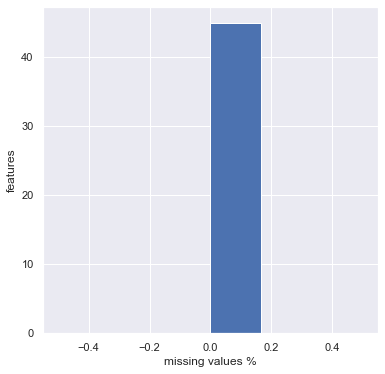

In [29]:
sns.distplot(a=control_df['missing_pct'], kde=False, hist_kws={'alpha':1})
plt.ylabel('features')
plt.xlabel('missing values %');

Now we're clear of missing values in the train dataset!

#### Checking variability of features

We've already removed the `NU_INSCRICAO` feature, which behaved like an ID. Now, let's take a look if any other feature behaves in such a way, or if any feature have only but one unique value.

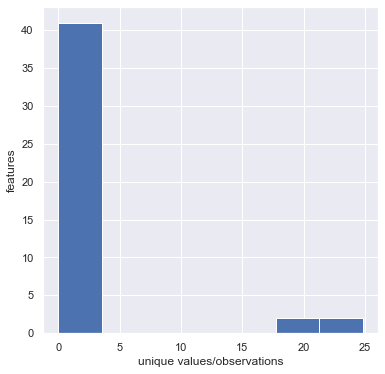

In [30]:
sns.distplot(a=control_df['unique_rate'], kde=False, bins=7, hist_kws={'alpha':1})
plt.ylabel('features')
plt.xlabel('unique values/observations');

In [31]:
control_df.sort_values('unique_rate')

,column,dtype,missing_pct,uniques,unique_rate
12,IN_CEGUEIRA,int64,0.0,1,0.01
18,IN_IDOSO,int64,0.0,2,0.01
17,IN_GESTANTE,int64,0.0,2,0.01
16,IN_SABATISTA,int64,0.0,2,0.01
15,IN_DISCALCULIA,int64,0.0,2,0.01
14,IN_DISLEXIA,int64,0.0,2,0.01
13,IN_SURDEZ,int64,0.0,2,0.01
11,IN_BAIXA_VISAO,int64,0.0,2,0.01
10,IN_TREINEIRO,int64,0.0,2,0.01
29,TP_LINGUA,int64,0.0,2,0.01


We can see that the feature `IN_CEGUEIRA` have only one unique value. Let's take a closer look.

In [32]:
train_df['IN_CEGUEIRA'].value_counts()

0    13730
Name: IN_CEGUEIRA, dtype: int64

Indeed, this won't add any information. Let's remove and add it to the list `columns_to_drop` for later use on the preprocessing of the test data.

In [33]:
columns_to_drop = columns_to_drop + ['IN_CEGUEIRA']

dropColumns(df=train_df, cols=columns_to_drop)
control_df = makeControlDf(train_df)

columns_to_drop

['TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'IN_CEGUEIRA']

Let's also check the correlation of the non-object features with our target feature `NU_NOTA_MT`.


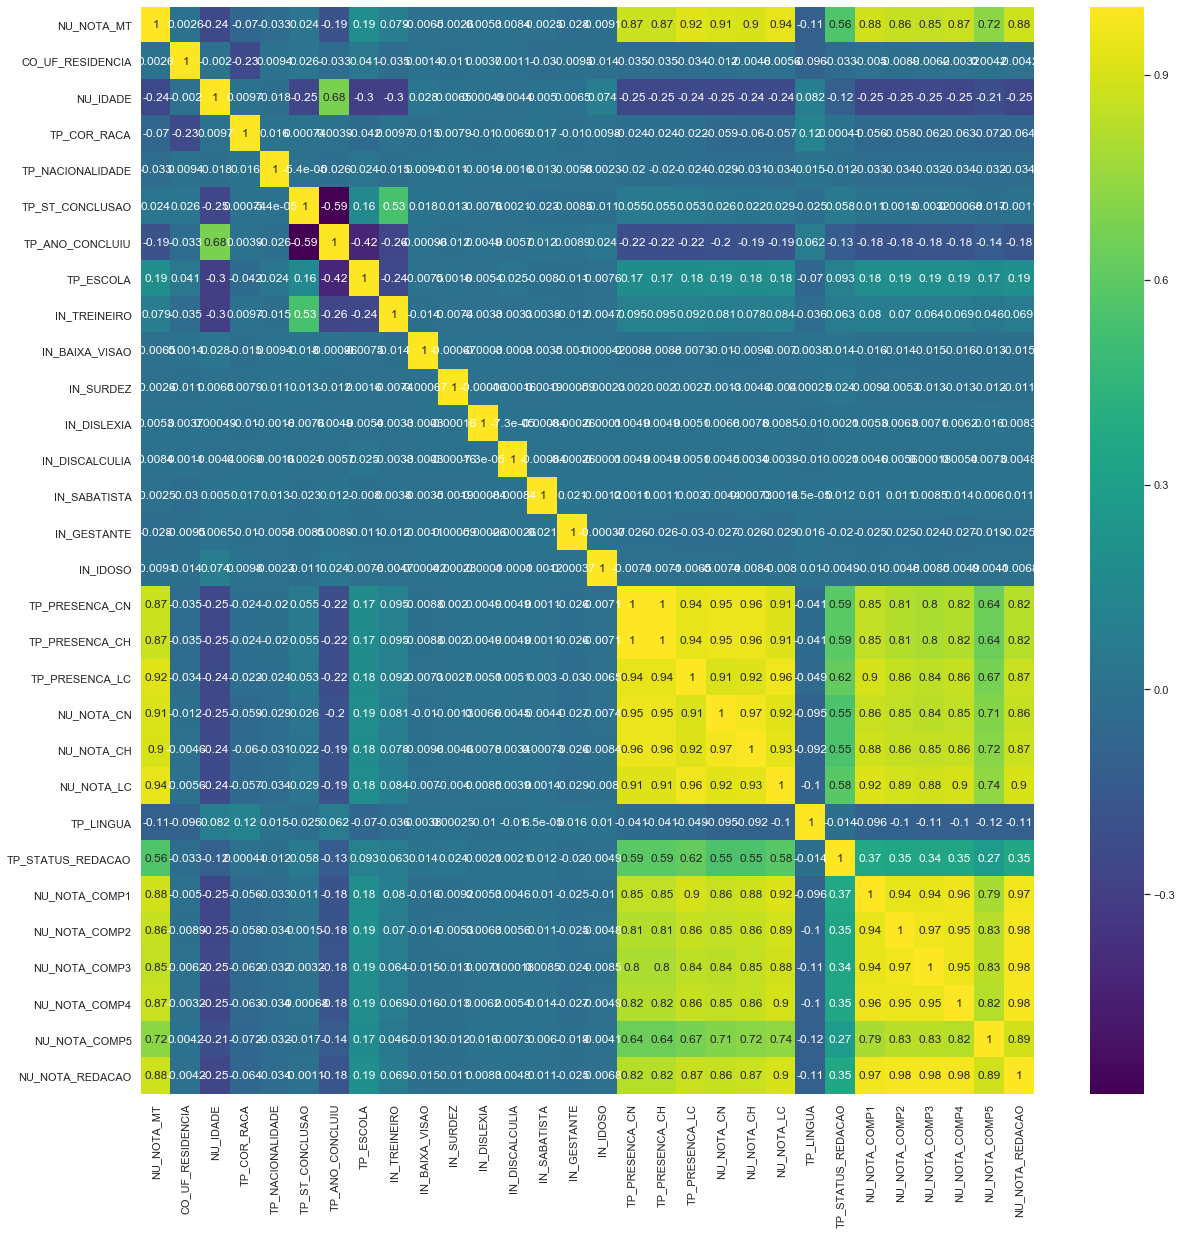

In [34]:
plt.figure(figsize=(20, 20))
sns.heatmap(train_df.corr(), cmap='viridis', annot=True);

The features that are most correlated with the target `NU_NOTA_MT` are the ones related to the student's presence during the test (`TP_PRESENCA_CN`, `TP_PRSENCA_TN`, `TP_PRESENCA_LC`), the students' grades on the other tests (`NU_NOTA_CN`, `NU_NOTA_CH`and `NU_NOTA_LC`) as well as features related to the essay test results and status (`TP_STATUS_REDACAO` to `NU_NOTA_REDACAO`).

#### Checking dtypes

Now, let's check if the features' types are functional/correct.

In [35]:
control_df['dtype'].value_counts()

int64      19
object     14
float64    11
Name: dtype, dtype: int64

* **The integers features are:**

In [36]:
control_df[control_df['dtype']=='int64']['column']

1     CO_UF_RESIDENCIA
3             NU_IDADE
5          TP_COR_RACA
6     TP_NACIONALIDADE
7      TP_ST_CONCLUSAO
8      TP_ANO_CONCLUIU
9            TP_ESCOLA
10        IN_TREINEIRO
11      IN_BAIXA_VISAO
12           IN_SURDEZ
13         IN_DISLEXIA
14      IN_DISCALCULIA
15        IN_SABATISTA
16         IN_GESTANTE
17            IN_IDOSO
18      TP_PRESENCA_CN
19      TP_PRESENCA_CH
20      TP_PRESENCA_LC
28           TP_LINGUA
Name: column, dtype: object

The feature `CO_UF_RESIDENCIA` is the same as the feature `SG_UF_RESIDENCIA`, both have information about the state where the student lives, so the first can be droped.

In [39]:
columns_to_drop.append('CO_UF_RESIDENCIA')

dropColumns(df=train_df, cols=['CO_UF_RESIDENCIA'])
control_df = makeControlDf(train_df)

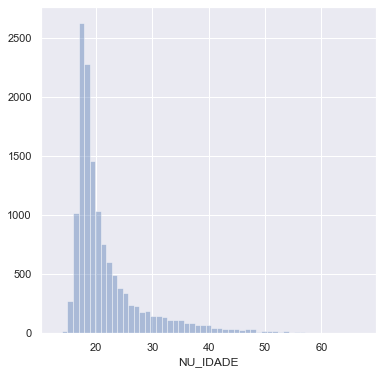

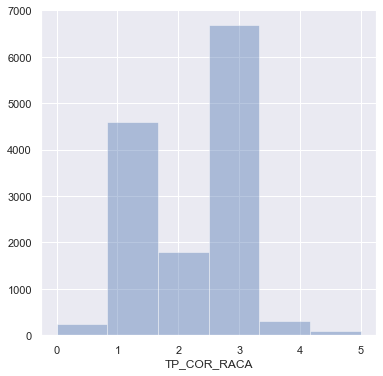

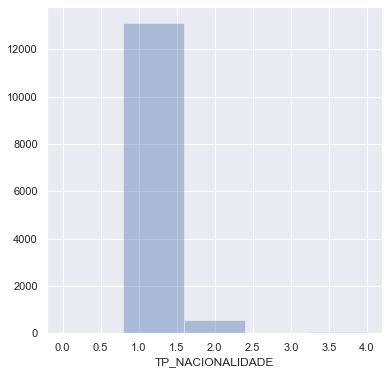

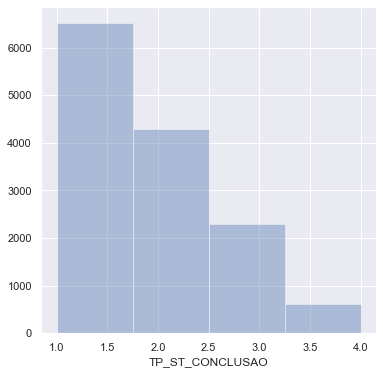

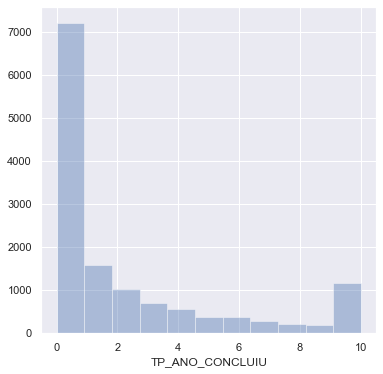

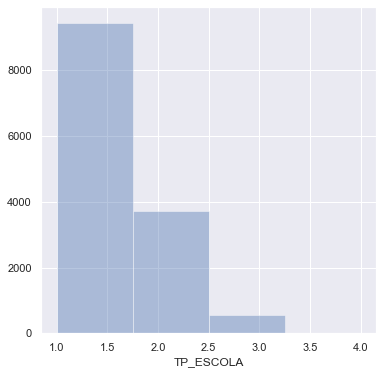

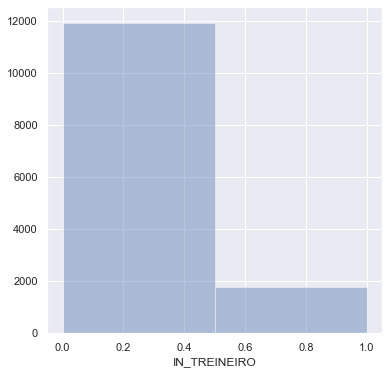

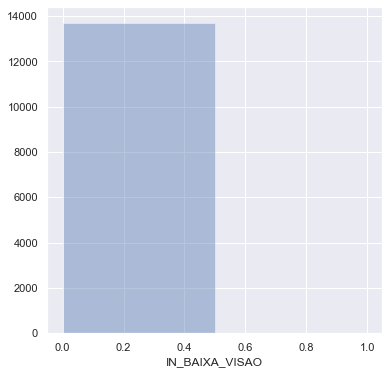

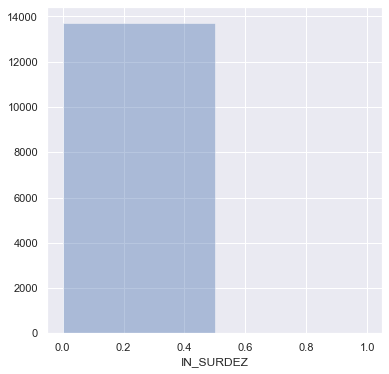

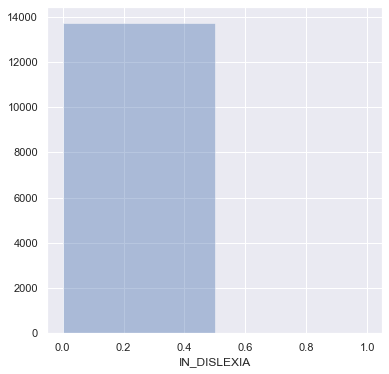

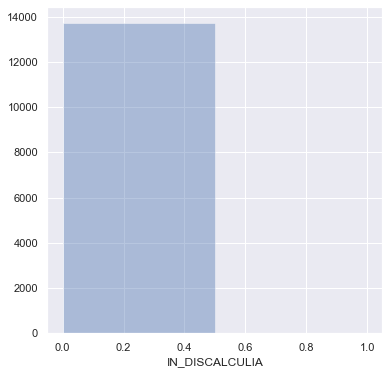

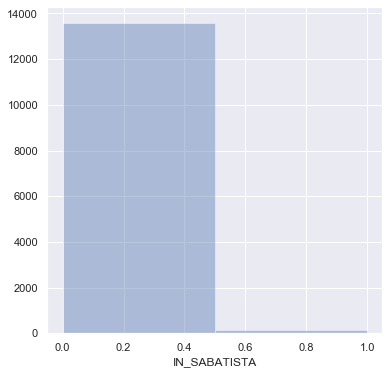

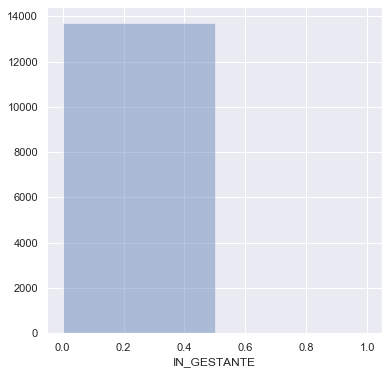

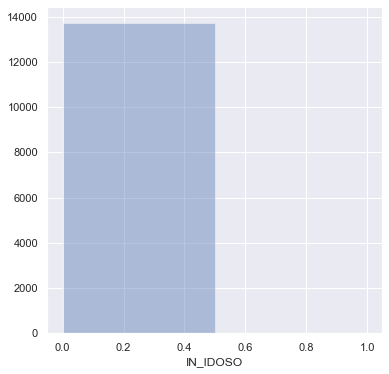

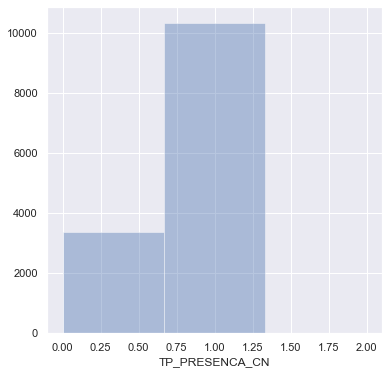

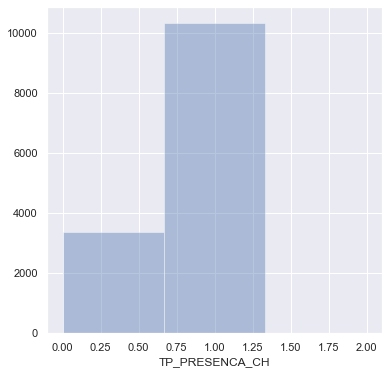

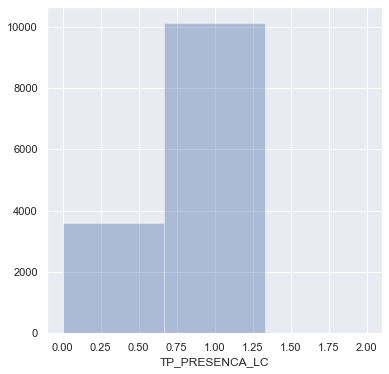

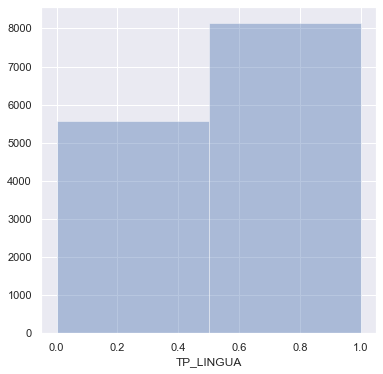

In [40]:
for col in control_df[control_df['dtype']=='int64']['column']:
    fig = plt.figure()
    sns.distplot(train_df[col], bins=train_df[col].nunique(), kde=False)

We can see through the distribution plots that the only feature that is actually an integer is `NU_IDADE`. It's distribution is very positively skewed. Later, we'll check the effects of some outliers on the results. Also, we'll standardize the numeric features.
The rest of the features in this list are indeed categorical, and some of them have very low variability. Let's check their relationship with the target variable.

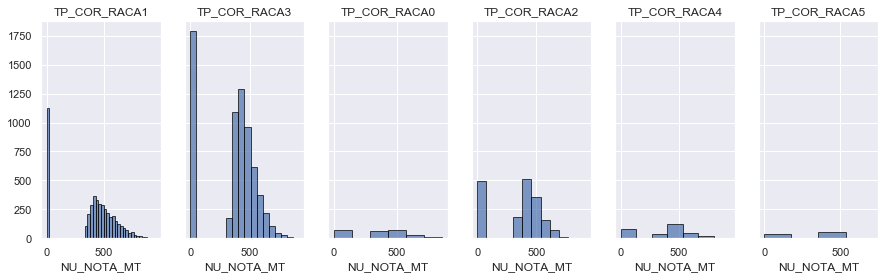

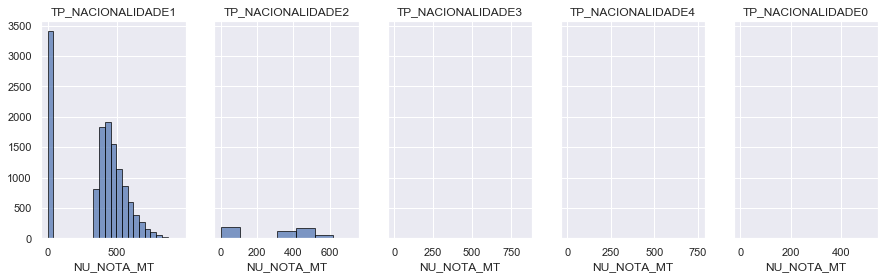

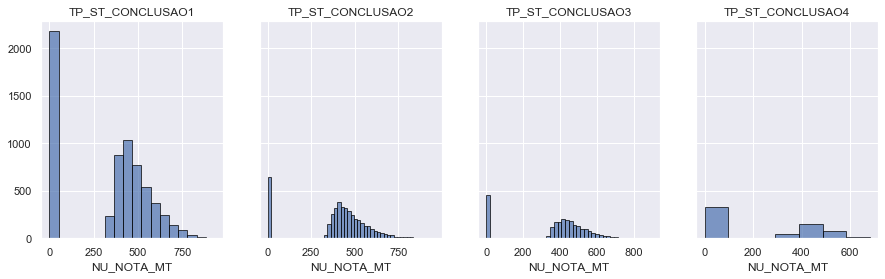

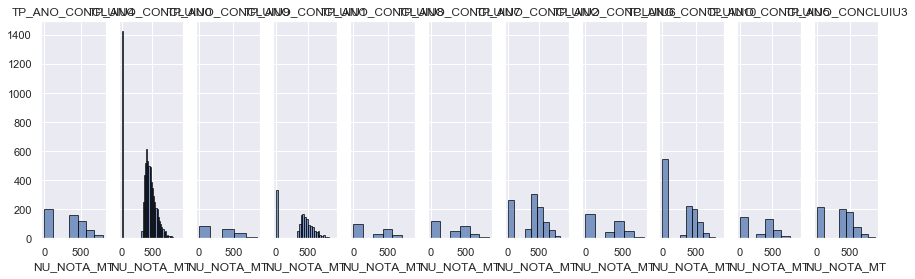

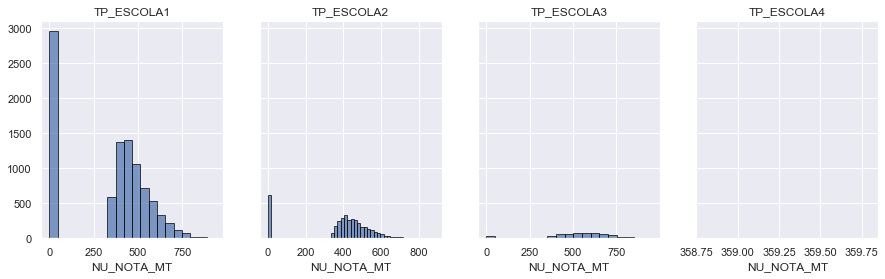

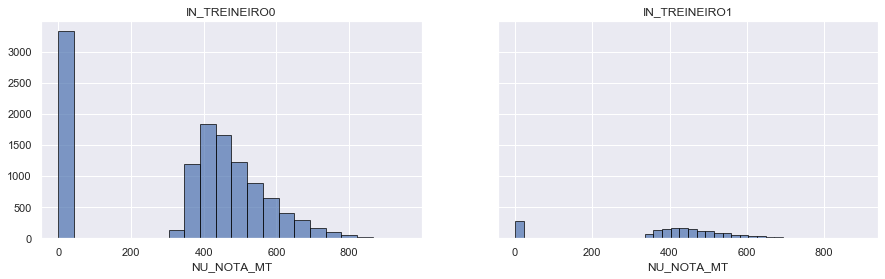

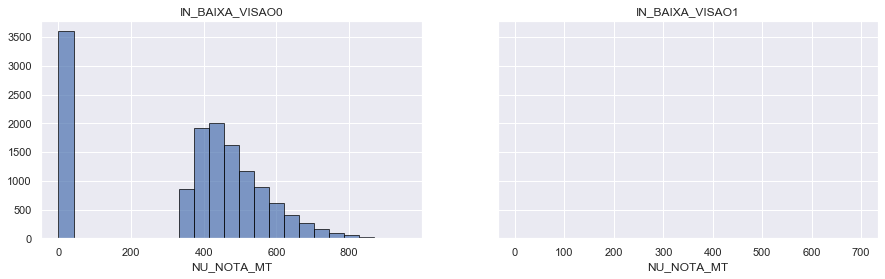

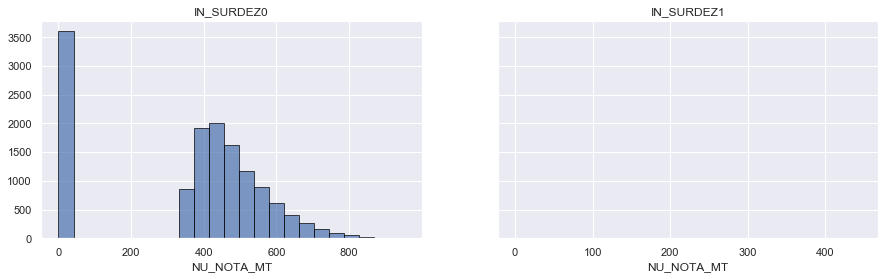

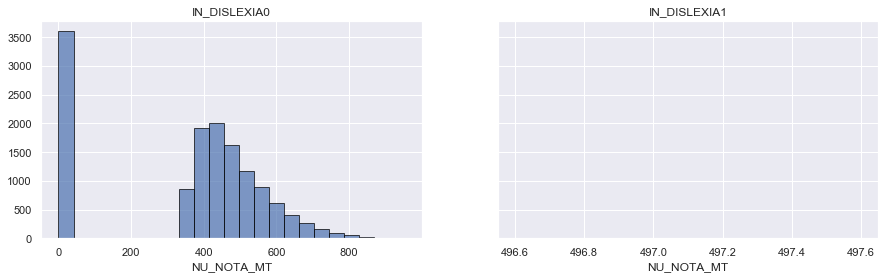

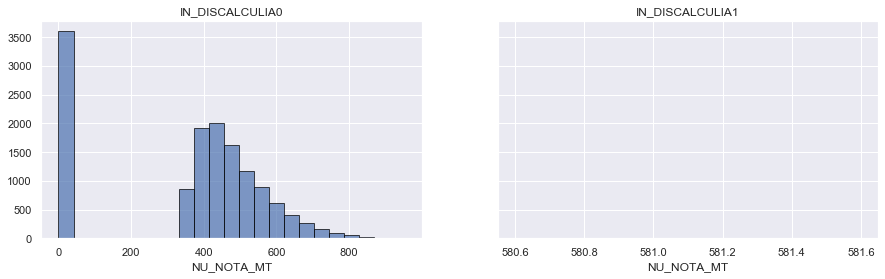

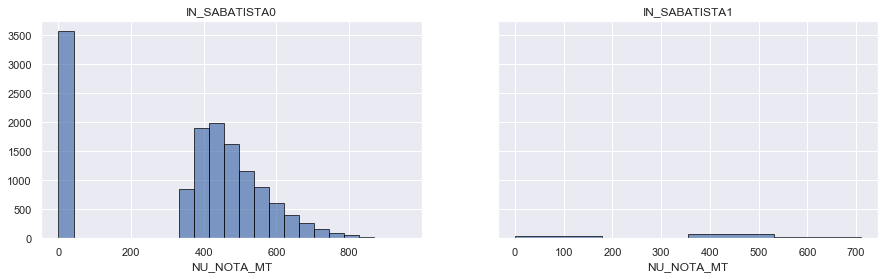

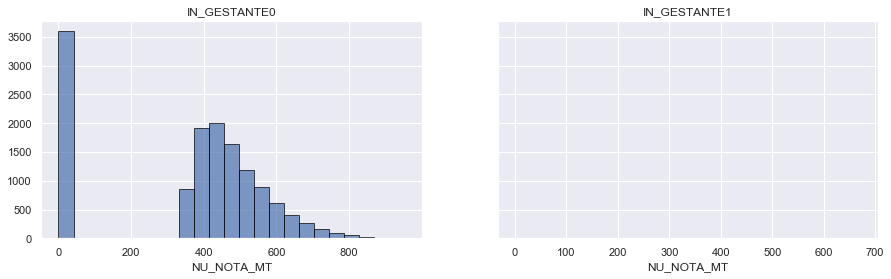

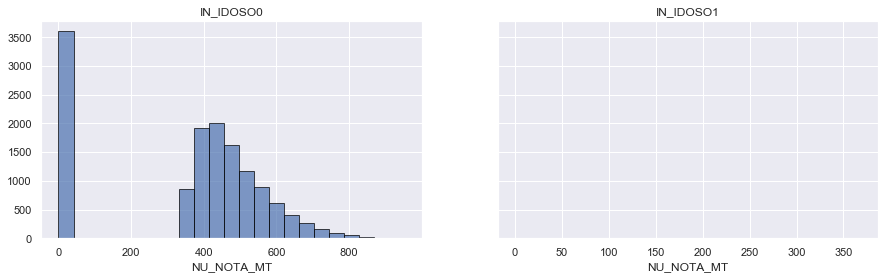

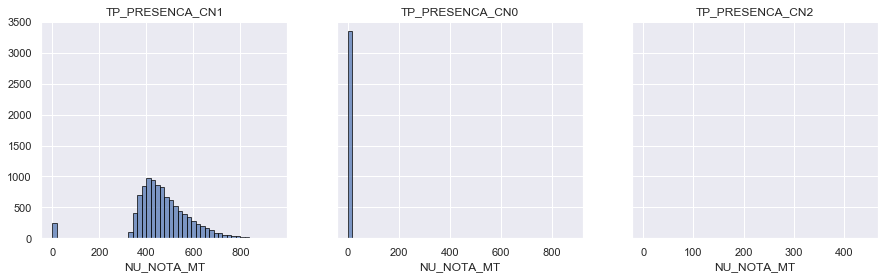

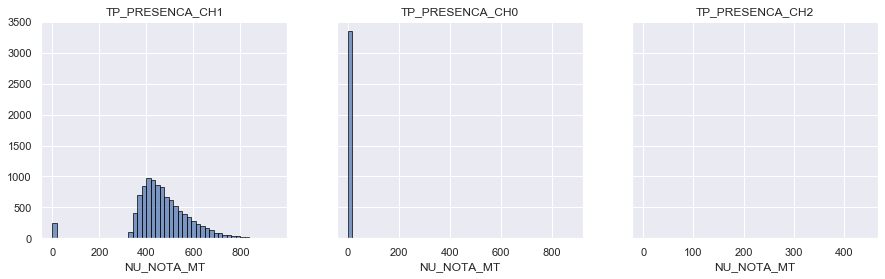

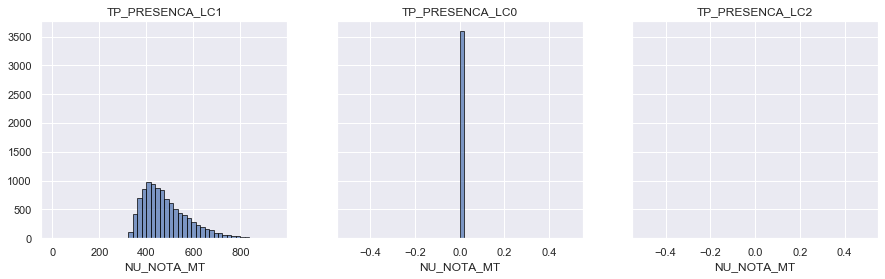

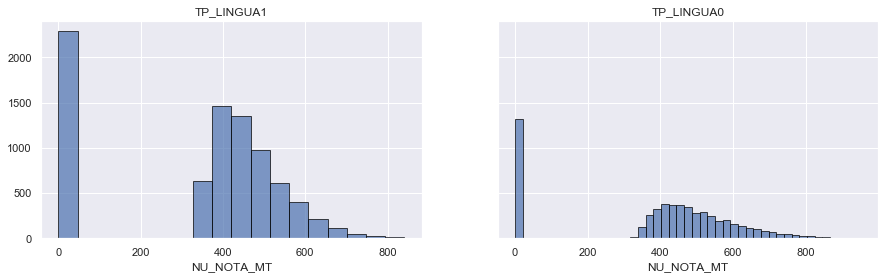

In [41]:
for col in control_df[(control_df['dtype']=='int64') & (control_df['column']!='NU_IDADE')]['column']:
    f, axes = plt.subplots(nrows=1, ncols=train_df[col].nunique(), figsize=(15, 4), sharey=True)
    for n, pos in zip(train_df[col].unique(), range(train_df[col].nunique())):
        sns.distplot(a=train_df[train_df[col]==n]['NU_NOTA_MT'], kde=False,
                     hist_kws={'edgecolor':'black',
                               'alpha':0.7,
                               'linewidth':1}, ax=axes[pos])
        axes[pos].set_title(col+str(n))

Many of these, like `IN_IDOSO`, have so many positive (1) cases that their distributions are impossible to see.  
Now, let's create lists of numeric and categorical variables to be used later in both train and test datasets pipelines.

In [42]:
numeric_features = ['NU_IDADE']
categorical_features = control_df[(control_df['dtype']=='int64')
                                  & (control_df['column']!='NU_IDADE')]['column'].to_list()

* **The floating point features are:**

In [43]:
control_df[control_df['dtype']=='float64']['column']

0            NU_NOTA_MT
24           NU_NOTA_CN
25           NU_NOTA_CH
26           NU_NOTA_LC
28    TP_STATUS_REDACAO
29        NU_NOTA_COMP1
30        NU_NOTA_COMP2
31        NU_NOTA_COMP3
32        NU_NOTA_COMP4
33        NU_NOTA_COMP5
34      NU_NOTA_REDACAO
Name: column, dtype: object

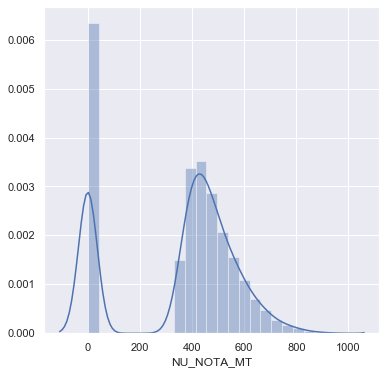

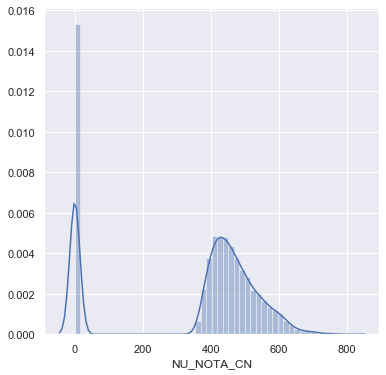

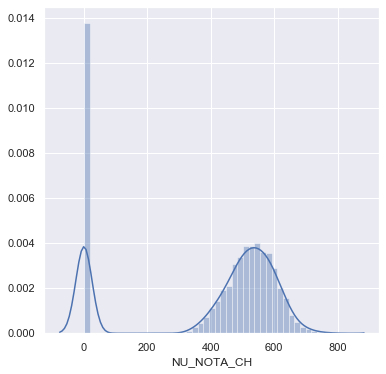

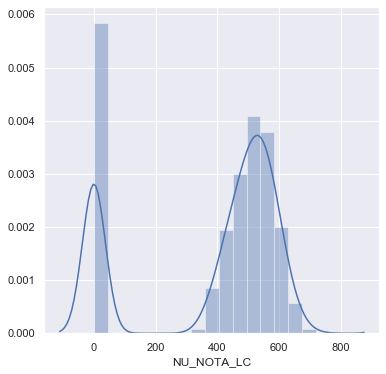

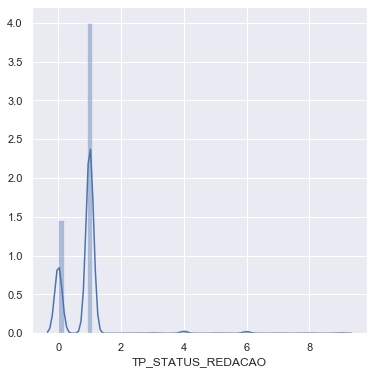

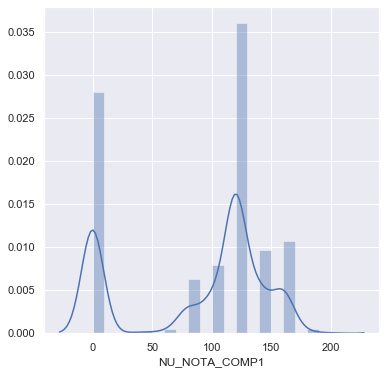

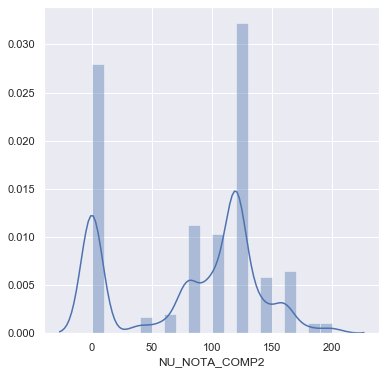

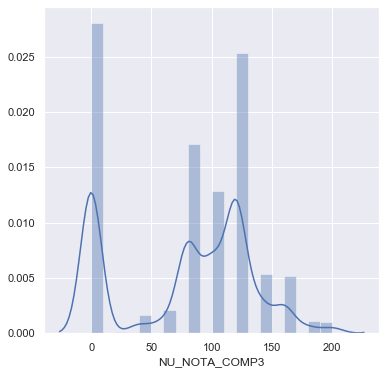

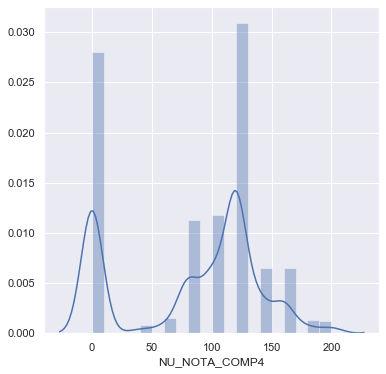

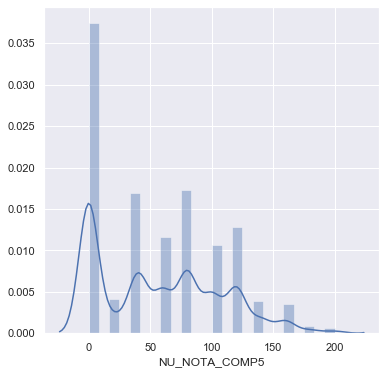

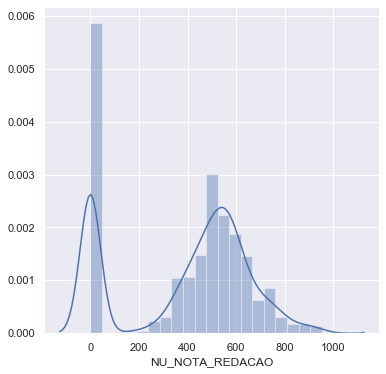

In [44]:
for col in control_df[control_df['dtype']=='float64']['column']:
    fig = plt.figure()
    sns.distplot(train_df[col])

The feature `TP_STATUS_REDACAO` is actually categorical.  
The features `NU_NOTA_COMPX` are numeric, but discrete.  
Features `NU_NOTA_CN`, `NU_NOTA_CH`, `NU_NOTA_LC` and `NU_NOTA_REDACAO` are all numeric.  
Let's add these to the respective lists for later use.

In [45]:
categorical_features.append('TP_STATUS_REDACAO')
numeric_features = numeric_features + control_df[(control_df['dtype']=='float64')  
                                                 & (control_df['column']!='TP_STATUS_REDACAO')]['column'].to_list()

* **The type object features are:**

In [46]:
control_df[control_df['dtype']=='object']['column']

1     SG_UF_RESIDENCIA
3              TP_SEXO
20         CO_PROVA_CN
21         CO_PROVA_CH
22         CO_PROVA_LC
23         CO_PROVA_MT
35                Q001
36                Q002
37                Q006
38                Q024
39                Q025
40                Q026
41                Q027
42                Q047
Name: column, dtype: object

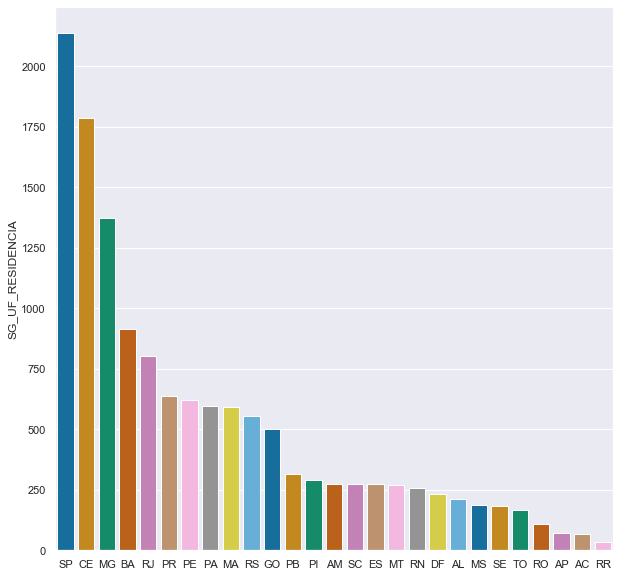

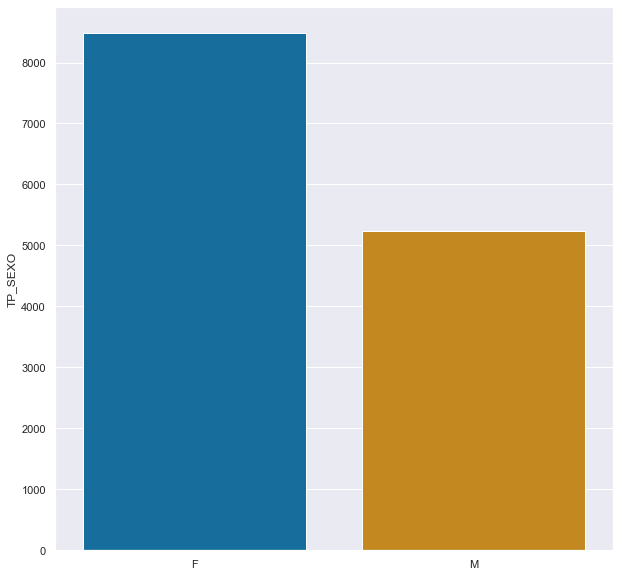

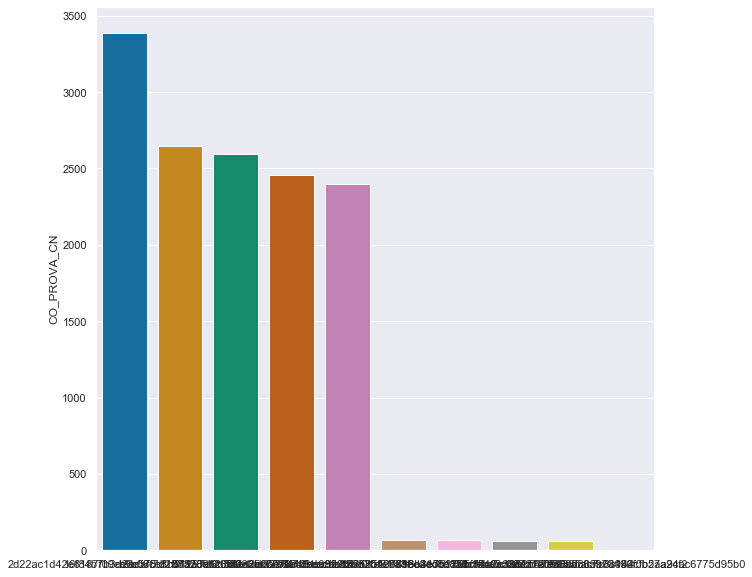

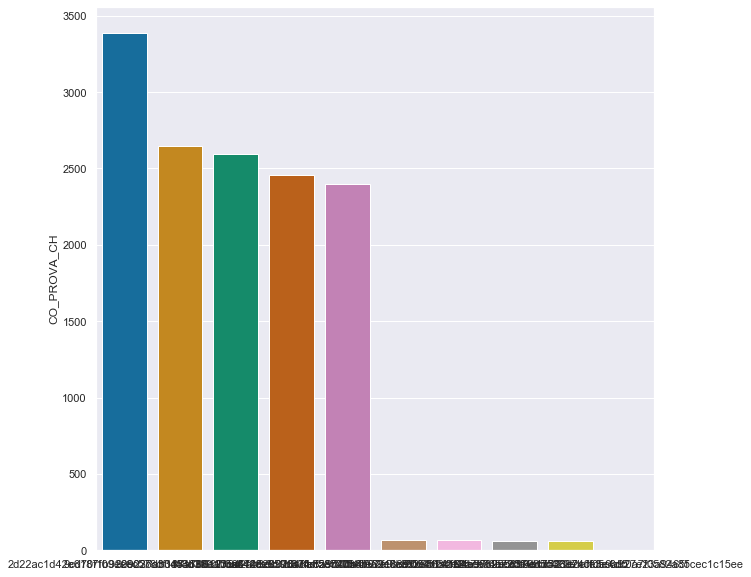

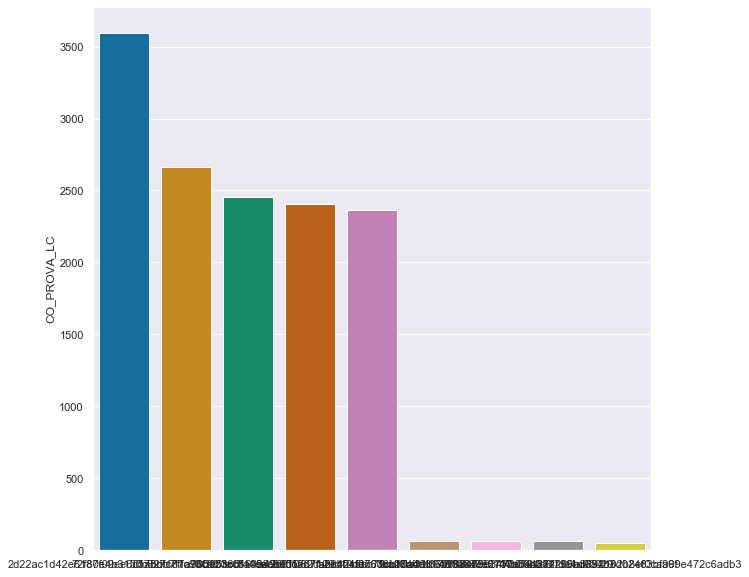

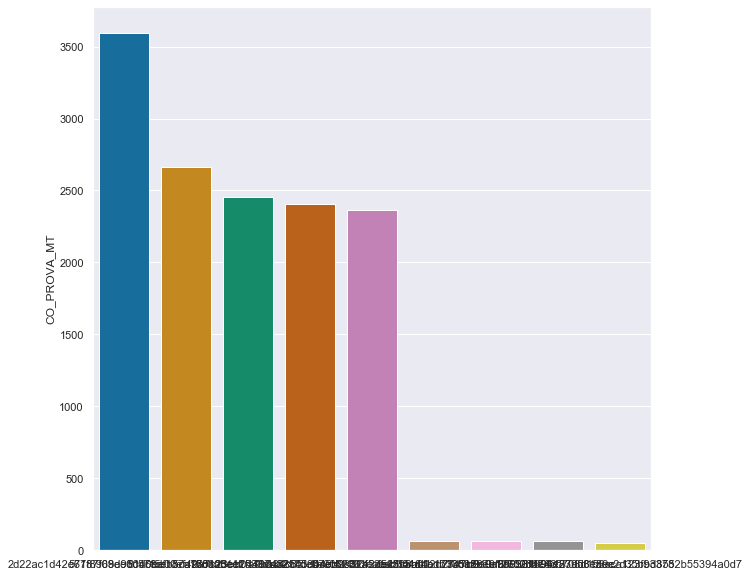

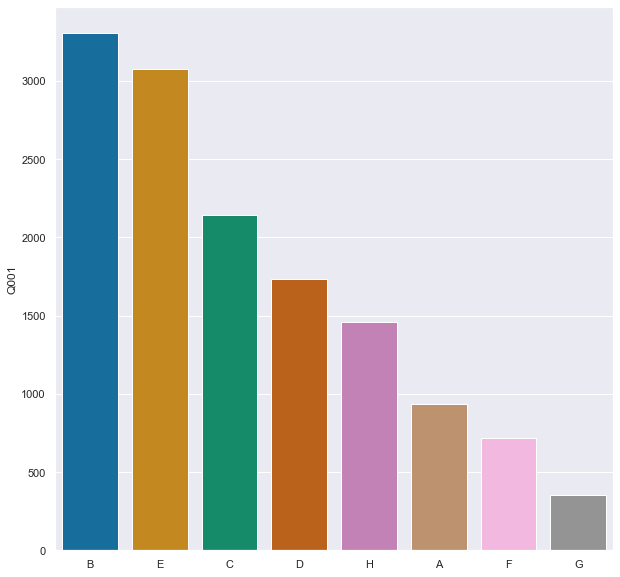

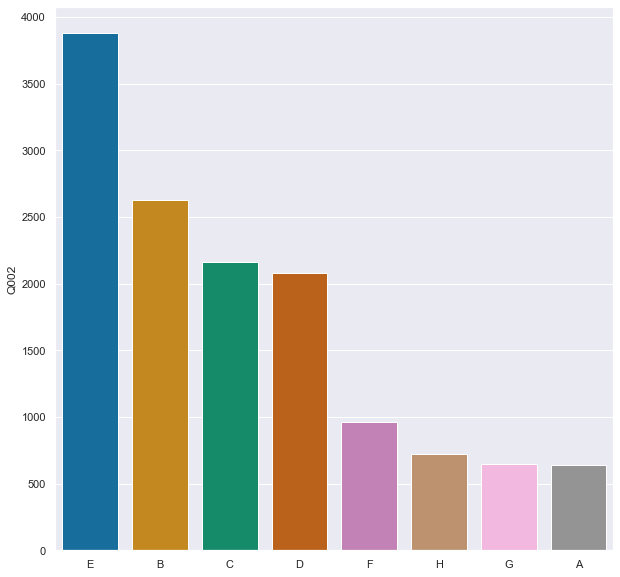

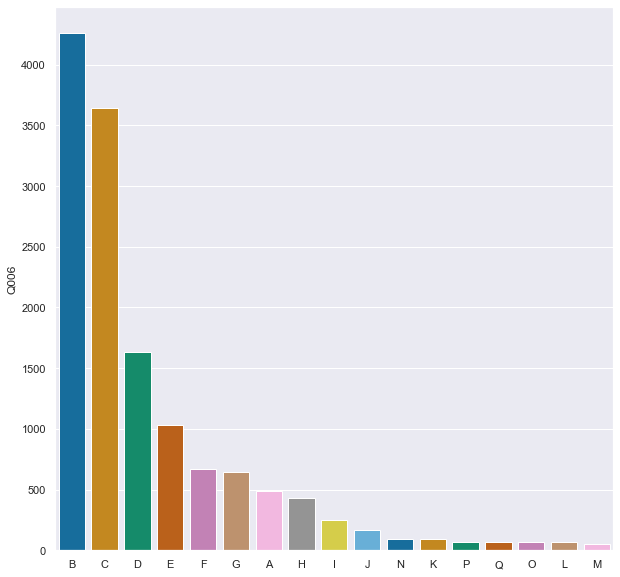

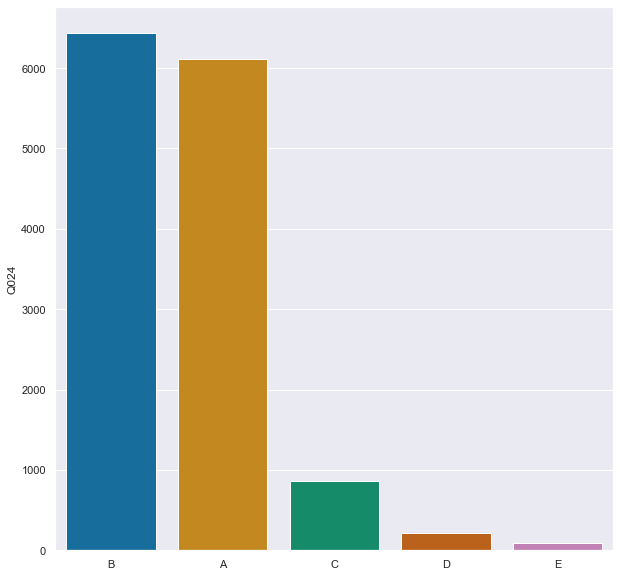

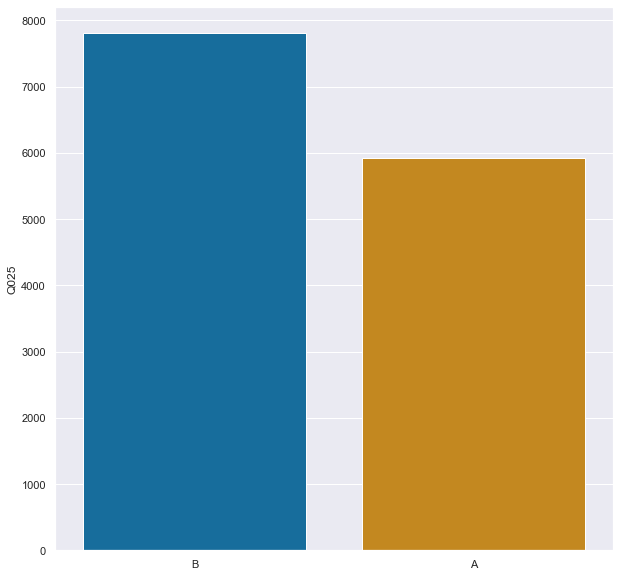

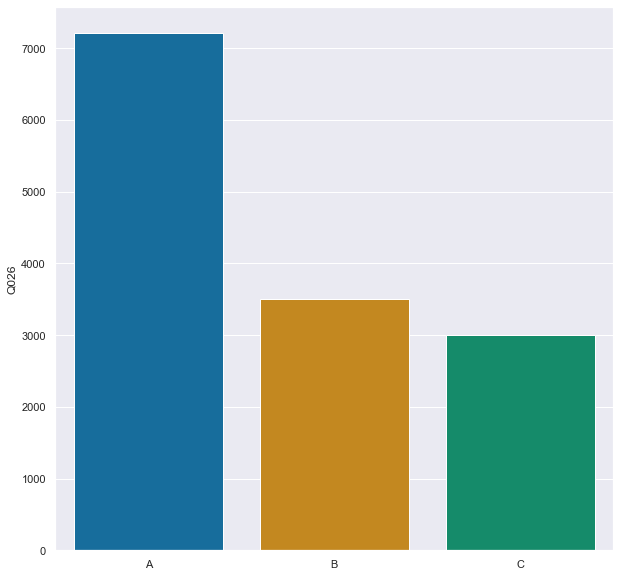

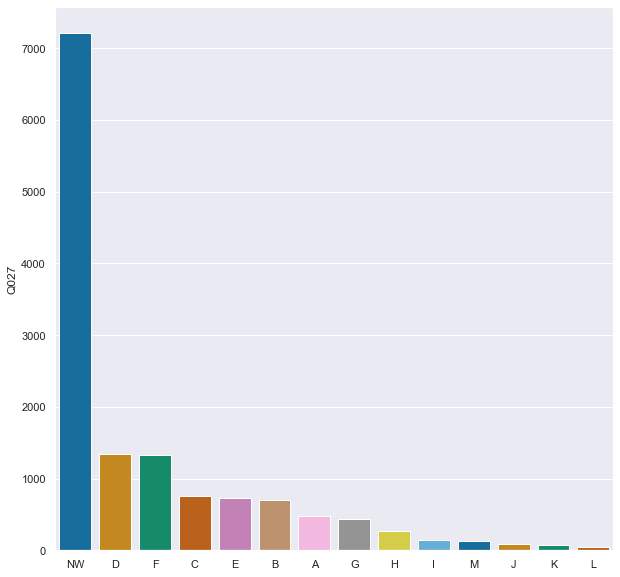

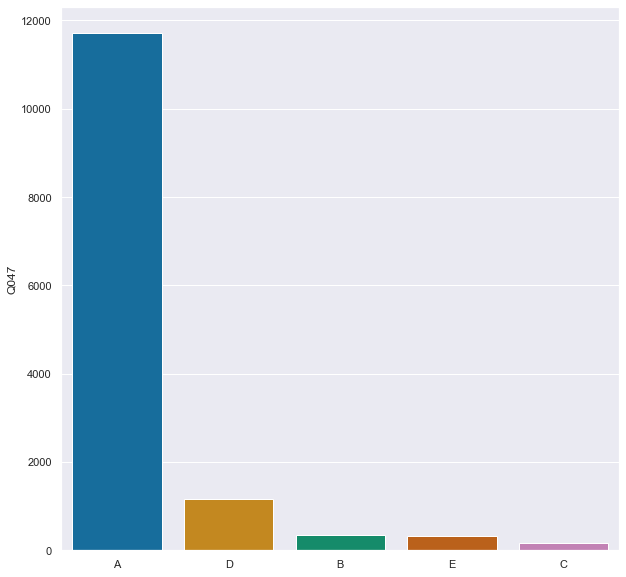

In [47]:
for col in control_df[control_df['dtype']=='object']['column']:
    fig = plt.figure(figsize=(10,10))
    sns.barplot(
        x=train_df[col].value_counts().index,
        y=train_df[col].value_counts(),
        palette="colorblind")

Some of the categorical features present most of the values in just a few categories. As a note - in these situations, it could be usefull to set these to a separate unified class (like "rares" or "others").  
Let's add these to the categorical features list.

In [48]:
categorical_features = categorical_features + control_df[control_df['dtype']=='object']['column'].to_list()

I found out that the test codes - `CO_PROVA_CN`, `CO_PROVA_MT`, `CO_PROVA_CH`, `CO_PROVA_LC` - weren't the same between train and test sets, as we can see below, so we'll drop them all.

In [49]:
test_codes = ['CO_PROVA_CN', 'CO_PROVA_MT', 'CO_PROVA_CH', 'CO_PROVA_LC']

for tc in test_codes:
    print(f'Is any test code {tc} from the test_df in the train_df?')
    asserting = np.any([code in train_df[tc] for code in test_df[tc]])
    asserting = False
    print(f'{asserting}\n')
    if not asserting:
        train_df.drop(tc, axis=1, inplace=True)
        categorical_features.remove(tc)   
        columns_to_drop.append(tc)
        
control_df = makeControlDf(train_df)

Is any test code CO_PROVA_CN from the test_df in the train_df?
False

Is any test code CO_PROVA_MT from the test_df in the train_df?
False

Is any test code CO_PROVA_CH from the test_df in the train_df?
False

Is any test code CO_PROVA_LC from the test_df in the train_df?
False



#### Metrics and Residual plotting functions

In [50]:
def makeMetrics(y_true, y_predicted, testname, old_df=None):
    '''
    Create a Pandas DataFrame with metrics for regression - mean absolute error
    (mean_ae), mean squared error (mse), root mean squared error (rmse),
    median absolute error (median_ae), R² (r2). Accepts dataframes created 
    with the same function and concatenates them to the new dataframe.
    :param y_true: vector with true response values.
    :param y_predicted: vector with predicted response values.
    :param testname: string to be used as index, use it to identify the experiment.
    :param old_df: None or Pandas Dataframe, if None a new dataframe is created,
    else, the new metrics are concatenated to the existing dataframe.
    :return: Pandas DataFrame with columns as metrics and indexes as experiments' names.
    '''
    metrics = {'mean_ae':mean_absolute_error(y_true, y_predicted).round(2),
               'mse':mean_squared_error(y_true, y_predicted).round(2),
               'rmse':np.sqrt(mean_squared_error(y_true, y_predicted)).round(2),
               'median_ae':median_absolute_error(y_true, y_predicted).round(2),
               'r2':r2_score(y_true, y_predicted).round(2)}
    
    metrics_df = pd.concat([old_df, pd.DataFrame(metrics, index=[testname])])
    return metrics_df

def plotResiduals(y_true, y_predicted, testname):
    '''
    Plot a graphic with residuals on y axis and true respose values on x axis.
    :param y_true: vector with true response values.
    :param y_predicted: vector with predicted response values.
    :param testname: string to be used as index, use it to identify the experiment.
    '''
    plt.figure()
    sns.scatterplot(x=y_true, y=(y_true - y_predicted))
    sns.lineplot(x=y_true, y=0, color='red')
    plt.title(testname)
    plt.ylabel('residuals')
    plt.xlabel('y');

#### Creating a pipeline for numeric and categorical values:

The following pipelines are:
* standardizing the numeric features
* encoding categorical features with OneHotEncoder
* adding the selected estimator to the pipeline (linear, ridge or lasso regression)
    * if promped to, it is also selecting and fitting the resulting features with RFECV
  
Let's remove our target, `NU_NOTA_MT`, from our numeric features, we do not want it in the pipeline.

In [51]:
numeric_features.remove('NU_NOTA_MT')

In [53]:
def makePipeline(estimator='LR',
                 RFE_CV=False,
                 random_state=None,
                 numeric_features=numeric_features,
                 categorical_features=categorical_features):
    '''
    Create a pipeline to standardize numeric features, encode categorical features with one hot encoding,
    and apply the selected estimator - linear regression, ridge regression or lasso regression. Also allows
    for the selection of RFECV, recursive feature elimination with cross validation for the selection of features.
    :param estimator: string. accepts values 'LR' for linear regression, 'ridge' for ridge regression, and
    'lasso' for lasso regression.
    :param RFE_CV: boolean. True adds the RFECV feature selector to the pipeline, False to not use it.
    :param random_state: int. Defines the random state of the rigde and lasso estimators.
    :param numeric_features: list with the numeric features for the pipeline to apply transformations on.
    :param categorical_features: list with the categorical features for the pipeline to apply transformations on.
    :return: pipeline estimator ready to be instanciated and used with the common scikit-learn terminology.
    '''
    
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    
    if estimator=='LR':
        selected_estimator = LinearRegression(fit_intercept=False, n_jobs=-1)
    elif estimator=='ridge':
        selected_estimator = Ridge(fit_intercept=False, random_state=random_state, max_iter=3000)
    elif estimator=='lasso':
        selected_estimator = Lasso(fit_intercept=False, random_state=random_state, max_iter=3000)
    else:
        raise ValueError
    
    if RFE_CV:
        baseline_LR_RFECV = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('RFERegression', RFECV(selected_estimator, n_jobs=-1))])
    
        return baseline_LR_RFECV
    
    else:
        baseline_LR = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('Regression', selected_estimator)])
        
        return baseline_LR        

### Train models

Now let's train some models and make some experiments with the dataset.

#### Baseline Linear Regression

First, we'll train a linear regression model.

In [54]:
X = train_df.drop('NU_NOTA_MT', axis=1)
y = train_df['NU_NOTA_MT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [55]:
baseline_LR = makePipeline()
baseline_LR.fit(X_train, y_train);
y_LR = baseline_LR.predict(X_test)

In [56]:
metrics_df = makeMetrics(y_test, y_LR, 'baseline_LR')
metrics_df

,mean_ae,mse,rmse,median_ae,r2
baseline_LR,46.48,4133.32,64.29,32.13,0.92


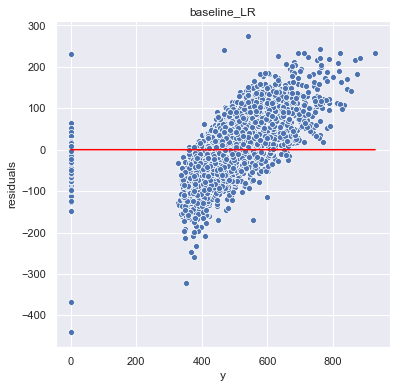

In [57]:
plotResiduals(y_test, y_LR, 'baseline_LR')

It seems like the Linear Regression estimator is overestimating predictions when the true value is higher than 600, and it's underestimating predictions when the true value is lower than the same threshold.  
We've seen the distributions of numeric features before, and some outliers are possible, and some categorical features had categories with very few values allocated to them.  
Also, it's possible to see that there's a clear gap between the grades. Observe the x-axis (y), students have grades between about 300 and 900, if their grade is bellow that, it is equal 0. That said, it's ok to assume that every estimate that is inferior to a similar threshold, say like, 200, should also be 0 - we can transform these values into 0s and test the metrics again.

In [58]:
residuals_df = pd.concat([y_test, pd.DataFrame(y_LR).set_index(y_test.index), y_test-y_LR], axis=1)
residuals_df.columns = ['target', 'predicted', 'residual']
change_to_zeroes = residuals_df[(residuals_df['predicted'] < 200)].index
residuals_df.loc[change_to_zeroes, 'predicted'] = residuals_df.loc[change_to_zeroes, 'predicted'].apply(lambda x: 0)

In [59]:
makeMetrics(residuals_df['target'], residuals_df['predicted'], 'changed0', old_df=metrics_df)

,mean_ae,mse,rmse,median_ae,r2
baseline_LR,46.48,4133.32,64.29,32.13,0.92
changed0,42.65,4011.76,63.34,29.76,0.93


Indeed, this improved our metrics!

#### Outliers


Let's see what kind of potential outliers there are in our dataset. They might be real fenomena that we want to capture in our model. Below are some functions to detect the outliers and to run several models with them removed - or one by one, or all of them at once.

In [60]:
def detectOutliers(df, method='box', std_threshold=3):
    '''
    Detect outliers using IQR or the standard deviation.
    :param df: Pandas DataFrame to detect outliers in. Should have numeric features listed in
    the variable 'numeric_features'.
    :param method: accepts 'box' or 'std' strings. 'box' detects outliers using IQR - values outside
    of the boundaries [q1 - 1.5 * iqr, q3 + 1.5 * iqr]. 'std' detects outliers using std
    - values outside of the boundaries [mean - threshold * std, mean + threshold * std].
    :param std_threshold: int that represents the threshold to be used with the standard deviation
    method (std).
    :return: Pandas DataFrame listing features that have outliers ('column', the detection interval 
    ('interval'), number of outliers ('outliers'), outliers under the threshold ('under_threshold'),
    outliers above the threshold ('above_threshold'), index of outliers ('index').    
    '''
    outliers = {'column':[],'interval':[],'outliers':[],'under_threshold':[],'above_threshold':[], 'index':[]}
    if method == 'box':
        for col in numeric_features:
            q1 = df[col].quantile(q=0.25)
            q3 = df[col].quantile(q=0.75)
            iqr = q3-q1
            low_threshold = q1 - 1.5 * iqr
            high_threshold = q3 + 1.5 * iqr
            interval = (low_threshold.round(2), high_threshold.round(2))
            outlier_list = df[(df[col]<interval[0]) | (df[col]>interval[1])][col]
            outliers['column'].append(col)
            outliers['interval'].append(interval)
            outliers['outliers'].append(outlier_list.count())
            outliers['under_threshold'].append(df[(df[col]<interval[0])][col].count())
            outliers['above_threshold'].append(df[(df[col]>interval[1])][col].count())
            outliers['index'].append(outlier_list.index.array)
            
    elif method == 'std':
        for col in numeric_features:
            outlier_mean = df[col].mean()
            outlier_std = df[col].std()
            low_threshold = outlier_mean - std_threshold * outlier_std
            high_threshold = outlier_mean + std_threshold * outlier_std
            interval = (low_threshold.round(2), high_threshold.round(2))
            outlier_list = df[(df[col]<interval[0]) | (df[col]>interval[1])][col]
            outliers['column'].append(col)
            outliers['interval'].append(interval)
            outliers['outliers'].append(outlier_list.count())
            outliers['under_threshold'].append(df[(df[col]<interval[0])][col].count())
            outliers['above_threshold'].append(df[(df[col]>interval[1])][col].count())
            outliers['index'].append(outlier_list.index.array)
            
    outliers_df = pd.DataFrame(outliers).set_index('column')
    return outliers_df

In [66]:
def runOutliersExperiment(df,
                          metrics_df,
                          method='std',
                          std_threshold=3,
                          rm_all_at_once=False,
                          plot=False):
    '''
    Run linear regression experiments by removing the outliers using IQR or the standard deviation as parameters.
    Shows metrics and can also plot the residuals. Can remove all outliers at once or one by one.
    :param df: Pandas DataFrame to detect outliers in and to make estimates.
    :param metrics_df: Pandas DataFrame with metrics returned from other experiments. It can be passed
    here so that metrics from different experiments show on the same table, to make analysis 
    easier.
    :param method: accepts 'box' or 'std' strings. 'box' detects outliers using IQR - values outside
    of the boundaries [q1 - 1.5 * iqr, q3 + 1.5 * iqr]. 'std' detects outliers using std
    - values outside of the boundaries [mean - threshold * std, mean + threshold * std].
    :param std_threshold: int that represents the threshold to be used with the standard deviation
    method (std).
    :param rm_all_at_once: bool, if True, removes all outliers detected using the selected method and
    threshold, if False, removes one by one.
    :param plot: bool, if True plot residuals for all estimates.
    :return: Pandas DataFrame listing metrics for linear regression using different outlier removal
    threshold and method.    
    '''
    outliers = detectOutliers(df, method, std_threshold)
    
    if rm_all_at_once:
        outliers_idx = []
        for feature in outliers.index:
            outliers_idx = outliers_idx + [x for x in outliers.loc[feature, 'index'] if x not in outliers_idx]
        train_df_outliers = df.copy()
        train_df_outliers.drop(outliers_idx, inplace=True)
        X = train_df_outliers.drop('NU_NOTA_MT', axis=1)
        y = train_df_outliers['NU_NOTA_MT']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        LR_outliers = makePipeline()
        LR_outliers.fit(X_train, y_train);
        y_LR_outliers = baseline_LR.predict(X_test)

        metrics_df = makeMetrics(y_test, y_LR_outliers, 'LR_rm_all_outliers', metrics_df)
        
        if plot:
            plotResiduals(y_test, y_LR_outliers, 'LR_rm_all_outliers')
        
    else:
        for feature in outliers.index:
            train_df_outliers = df.copy()
            train_df_outliers.drop(outliers.loc[feature, 'index'], inplace=True)
            X = train_df_outliers.drop('NU_NOTA_MT', axis=1)
            y = train_df_outliers['NU_NOTA_MT']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            LR_outliers = makePipeline()
            LR_outliers.fit(X_train, y_train);
            y_LR_outliers = baseline_LR.predict(X_test)

            metrics_df = makeMetrics(y_test, y_LR_outliers, 'LR_rmoutliers_'+feature, metrics_df)
            if plot:
                plotResiduals(y_test, y_LR_outliers, 'LR_rmoutliers_'+feature)
    
    return metrics_df

Also, let's check the box plots for each numeric feature.

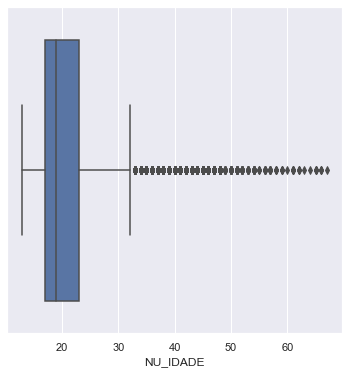

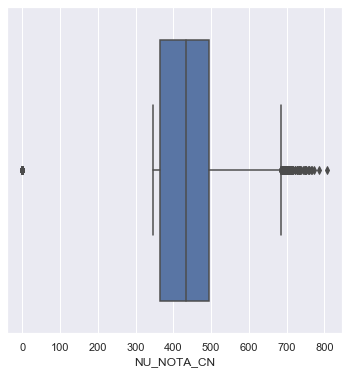

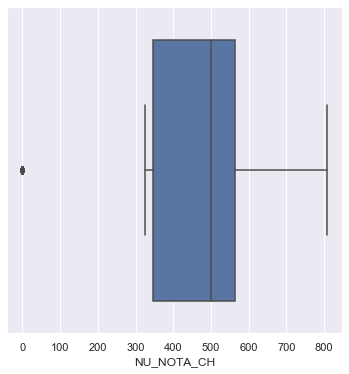

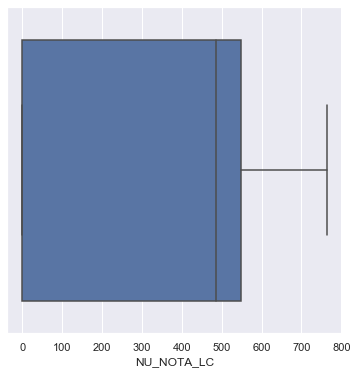

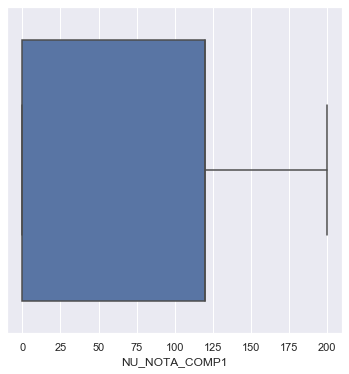

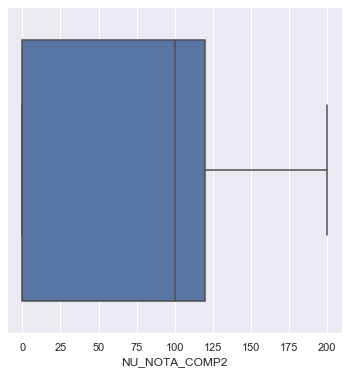

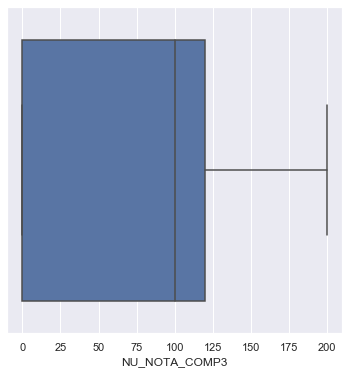

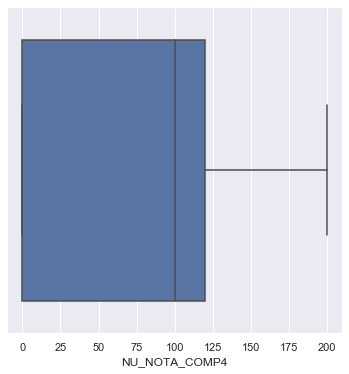

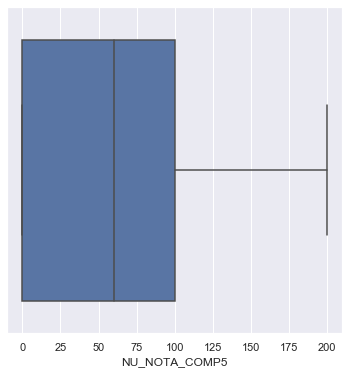

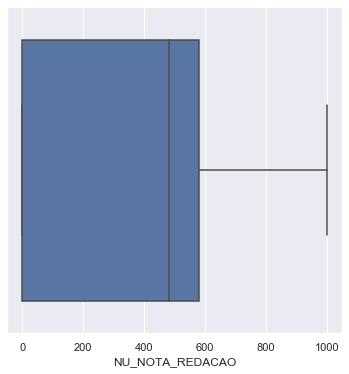

In [62]:
for col in numeric_features:
    fig = plt.figure()
    sns.boxplot(train_df[col])

Here, we're running experiments using linear regression with outliers removed for each feature separately. The threshold is equal 2 times the standard deviation.

In [67]:
outliers_experiment_metrics_2std = runOutliersExperiment(
    df=train_df,
    metrics_df=metrics_df,
    method='std',
    std_threshold=2)
outliers_experiment_metrics_2std

,mean_ae,mse,rmse,median_ae,r2
baseline_LR,46.48,4133.32,64.29,32.13,0.92
LR_rmoutliers_NU_IDADE,47.13,4144.94,64.38,33.31,0.92
LR_rmoutliers_NU_NOTA_CN,46.60,4116.40,64.16,32.13,0.92
LR_rmoutliers_NU_NOTA_CH,46.48,4133.32,64.29,32.13,0.92
LR_rmoutliers_NU_NOTA_LC,46.48,4133.32,64.29,32.13,0.92
LR_rmoutliers_NU_NOTA_COMP1,46.48,4133.32,64.29,32.13,0.92
LR_rmoutliers_NU_NOTA_COMP2,47.34,4219.58,64.96,33.44,0.92
LR_rmoutliers_NU_NOTA_COMP3,46.72,4196.45,64.78,32.02,0.92
LR_rmoutliers_NU_NOTA_COMP4,46.89,4185.40,64.69,32.48,0.92
LR_rmoutliers_NU_NOTA_COMP5,45.85,4049.66,63.64,32.33,0.92


Removing outliers from the `NU_NOTA_COMP5` and `NU_NOTA_REDACAO` with the 2\*std threshold improved the metrics mae, rmse and media_ae. What if we remove all the outliers? Let's try removing all the outliers with different thresholds.

In [68]:
outliers_experiment_metrics = metrics_df.copy()
std_threshold=np.linspace(2,4.5,6) #removing outliers outside of the thresholds defined by 2, 2.5, 3, 3.5, 4 and 4.5 stds
for x in std_threshold:
    outliers_experiment_metrics = runOutliersExperiment(
        df=train_df,
        metrics_df=outliers_experiment_metrics,
        method='std',
        std_threshold=x,
        rm_all_at_once=True)

std_threshold = pd.DataFrame([0] + list(std_threshold),
                             columns=['std_threshold'],
                             index=outliers_experiment_metrics.index)

outliers_experiment_metrics = pd.concat([outliers_experiment_metrics, std_threshold], axis=1)
outliers_experiment_metrics

,mean_ae,mse,rmse,median_ae,r2,std_threshold
baseline_LR,46.48,4133.32,64.29,32.13,0.92,0.0
LR_rm_all_outliers,46.09,4000.42,63.25,32.77,0.92,2.0
LR_rm_all_outliers,46.86,4220.39,64.96,32.96,0.92,2.5
LR_rm_all_outliers,47.15,4190.14,64.73,33.38,0.92,3.0
LR_rm_all_outliers,46.46,4053.51,63.67,32.96,0.92,3.5
LR_rm_all_outliers,46.79,4142.16,64.36,32.93,0.92,4.0
LR_rm_all_outliers,46.83,4094.19,63.99,33.70,0.92,4.5


So when removing the outliers with a threshold of 2\*std, we're able to reduce the errors just a bit. Removing outliers does not have a huge on the metrics though, specifically the R² score, so we'll not meddle with them.

#### LR, Ridge and Lasso baselines

Now let's also use ridge and lasso regresion models and evaluate them.

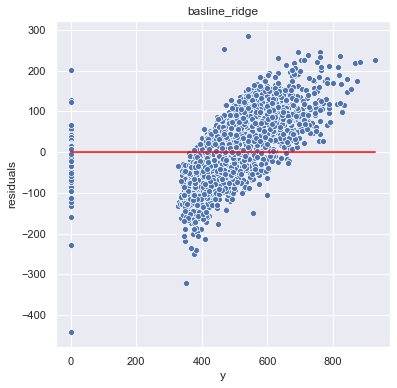

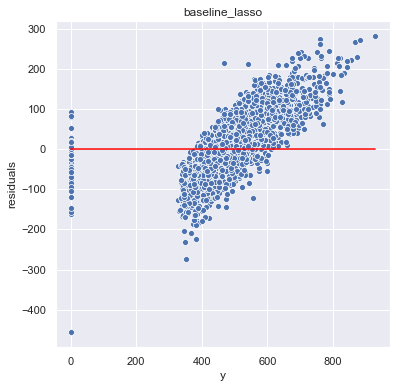

In [69]:
train_df_pre = train_df.copy()

X = train_df_pre.drop('NU_NOTA_MT', axis=1)
y = train_df_pre['NU_NOTA_MT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

baseline_ridge = makePipeline(estimator='ridge', random_state=42)
baseline_lasso = makePipeline(estimator='lasso', random_state=42)

baseline_ridge.fit(X_train, y_train)
baseline_lasso.fit(X_train, y_train)

y_ridge = baseline_ridge.predict(X_test)
y_lasso = baseline_lasso.predict(X_test)

for experiment, y_predicted in zip(['basline_ridge', 'baseline_lasso'], [y_ridge, y_lasso]):
    metrics_df = makeMetrics(y_test, y_predicted, experiment, metrics_df)
    plotResiduals(y_test, y_predicted, experiment)

In [70]:
metrics_df

,mean_ae,mse,rmse,median_ae,r2
baseline_LR,46.48,4133.32,64.29,32.13,0.92
basline_ridge,46.63,4161.89,64.51,32.47,0.92
baseline_lasso,48.12,4375.46,66.15,33.57,0.92


Surprisingly, the baseline linear regression performed better than the other algorithms. Let's use RFECV to do some feature selection and see if we can improve the metrics.

DO YOU WANT TO RUN *LINEAR, *RIDGE AND *LASSO REGRESSIONS WITH *RFECV? Y/NY
Ok, lets roll. ETA 15 min
Creating pipelines . . . 
Fitting linear regression . . .
Fitting ridge regression . . . 
Fitting lasso regression . . . 
Estimating responses . . . 
Saving metrics and plotting . . . 


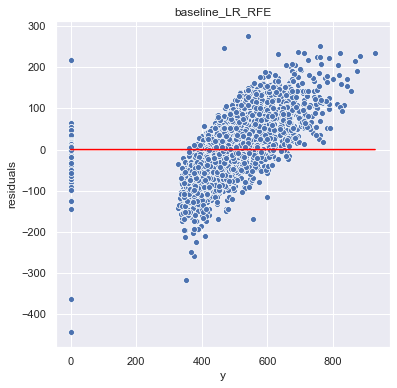

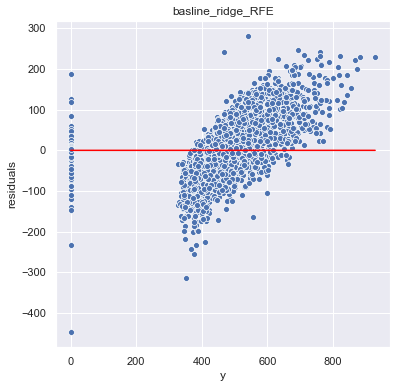

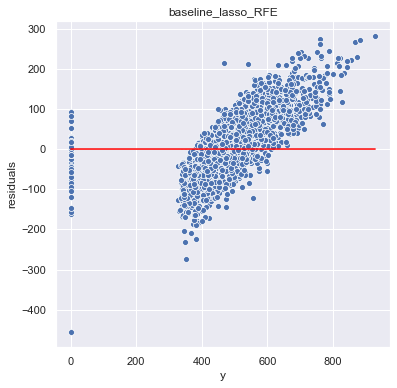

In [71]:
while True:
    x = input('DO YOU WANT TO RUN *LINEAR, *RIDGE AND *LASSO REGRESSIONS WITH *RFECV? Y/N')
    x = x.lower()
    if x == 'y':
        print('Ok, lets roll. ETA 15 min')
        #THIS WILL TAKE A WHILE
        print('Creating pipelines . . . ')
        baseline_LR_RFE = makePipeline(RFE_CV=True)
        baseline_ridge_RFE = makePipeline(estimator='ridge', RFE_CV=True, random_state=42)
        baseline_lasso_RFE = makePipeline(estimator='lasso', RFE_CV=True, random_state=42)

        print('Fitting linear regression . . .')
        baseline_LR_RFE.fit(X_train, y_train)
        print('Fitting ridge regression . . . ')
        baseline_ridge_RFE.fit(X_train, y_train)
        print('Fitting lasso regression . . . ')
        baseline_lasso_RFE.fit(X_train, y_train)

        print('Estimating responses . . . ')
        y_LR = baseline_LR_RFE.predict(X_test)
        y_ridge = baseline_ridge_RFE.predict(X_test)
        y_lasso = baseline_lasso_RFE.predict(X_test)

        print('Saving metrics and plotting . . . ')
        for experiment, y_predicted in zip(['baseline_LR_RFE', 'basline_ridge_RFE', 'baseline_lasso_RFE'], [y_LR, y_ridge, y_lasso]):
            metrics_df = makeMetrics(y_test, y_predicted, experiment, metrics_df)
            plotResiduals(y_test, y_predicted, experiment)
        break
    elif x=='n':
        print('Ok, didnt want to anyway.')
        break
    else:
        print('Please, answer with Y or N')

In [72]:
metrics_df

,mean_ae,mse,rmse,median_ae,r2
baseline_LR,46.48,4133.32,64.29,32.13,0.92
basline_ridge,46.63,4161.89,64.51,32.47,0.92
baseline_lasso,48.12,4375.46,66.15,33.57,0.92
baseline_LR_RFE,46.38,4140.21,64.34,32.45,0.92
basline_ridge_RFE,46.60,4147.67,64.40,32.43,0.92
baseline_lasso_RFE,48.12,4375.08,66.14,33.57,0.92


The baseline LR did better than the other models! Using RFE did improve it's mean absolute error, but didn't improve it's root mean square error and median absolute error. The R² score remained roughly equal.  
Let's use the baseline LR to send our results for scoring, and then transform every prediction under 200 to 0, as done before

#### Processing test_values and sending to evaluation

Now, we'll use the whole train dataset to train the linear regression model, save the predictions along with the students ID in a csv file ('answers.csv') and send it to the evaluation system ([codenation](www.codenation.com.br)).  
Let's start by dropping the columns saved in the list `columns_to_drop` from the test dataset.

In [73]:
nu_inscricao = test_df['NU_INSCRICAO']
trial_df = test_df.copy()
trial_df.drop('NU_INSCRICAO', axis=1, inplace=True)
trial_df = trial_df.drop(columns_to_drop, axis=1)

In [74]:
X_train = train_df_pre.drop('NU_NOTA_MT', axis=1)
y_train = train_df_pre['NU_NOTA_MT']

LR_pipeline = makePipeline()
LR_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NU_IDADE', 'NU_NOTA_CN',
                                                   'NU_NOTA_CH', 'NU_NOTA_LC',
                                                   'NU_NOTA_COMP1',
                                                   'NU_NOTA_COMP2',
                                                   'NU_NOTA_COMP3',
                                                   'NU_NOTA_COMP4',
                                                   'NU_NOTA_COMP5',
                                                   'NU_NOTA_REDACAO']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                           

In [75]:
trial = pd.Series(LR_pipeline.predict(trial_df))
answer = pd.concat([nu_inscricao, trial], axis=1, keys=['NU_INSCRICAO', 'NU_NOTA_MT'])
answer['NU_NOTA_MT'] = answer['NU_NOTA_MT'].apply(lambda x: 0 if x < 200 else x)
answer.to_csv('answer.csv', index=False)

In [76]:
answer.head()

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,434.108836
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,442.875058
2,b38a03232f43b11c9d0788abaf060f7366053b6d,574.153430
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.000000
4,715494628a50142ce8cb17191cfe6d0f3cae0934,553.879849


**The scoring website gave us a whooping 93.58% score for these predictions! Great!**